# Notebook I - Climate Regime

<hr>
<hr>

## Importing Libraries

In [1]:
'''import supporting libraries'''

import numpy as np
import matplotlib.pyplot as plt
import imageio

import sys
sys.path.append('./code/') # add path to source code directory

## Reading Data

In [10]:
'''reading climate data'''

min_temp = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/min_temp.npy') # Celcius
max_temp = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/max_temp.npy') # Celcius
precipitation = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/precipitation.npy') # mm / day
short_rad = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/short_rad.npy') # W/m^2
wind_speed = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/wind_speed.npy') # m/s
rel_humidity = np.load('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/climate/relative_humidity.npy') # Fraction, and assumed as a constant 0.70

In [11]:
'''reading study area and elevation data'''

admin_mask = imageio.imread('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/LAO_Admin.tif');
srtm_elevation = imageio.imread('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/SRTM_Elevation.tif'); # m

## Climate Regime Calculations

In [12]:
'''importing of the ClimateRegime library. And passing climate data'''
import os
os.chdir('D:/3. Py-AEZ/PyAEZ/code')
import ClimateRegime

clim_reg = ClimateRegime.ClimateRegime()

# latitude limits of the study area
lat_min = 13.90
lat_max = 22.51

clim_reg.setStudyAreaMask(admin_mask, 0)
clim_reg.setLocationTerrainData(lat_min, lat_max, srtm_elevation)
clim_reg.setMonthlyClimateData(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [13]:
'''importing of the UtilitiesCalc library for saving results'''

import UtilitiesCalc
obj_utilities = UtilitiesCalc.UtilitiesCalc()

#### Thermal Climate

In [14]:
tclimate = clim_reg.getThermalClimate()

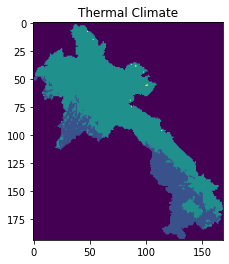

In [15]:
'''save and visualize result'''

plt.imshow(tclimate)
plt.title('Thermal Climate')
plt.show()

obj_utilities.saveRaster('D:/3. Py-AEZ/PyAEZ/sample_data/input_5/LAO_Admin.tif','D:/3. Py-AEZ/PyAEZ/sample_data/output/NB1/ThermalClimate1.tif', tclimate)

#### Thermal Zone

In [ ]:
tzone = clim_reg.getThermalZone()

In [ ]:
'''save and visualize result'''

plt.imshow(tzone)
plt.title('Thermal Zone')
plt.show()

obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif','./sample_data/output/NB1/ThermalZone.tif', tzone)

#### Thermal LGP

In [ ]:
lgp0 = clim_reg.getThermalLGP0()
lgp5 = clim_reg.getThermalLGP5()
lgp10 = clim_reg.getThermalLGP10()

In [ ]:
'''save and visualize result'''

plt.imshow(lgp0)
plt.title('LGP 0')
plt.show()

plt.imshow(lgp5)
plt.title('LGP 5')
plt.show()

plt.imshow(lgp10)
plt.title('LGP 10')
plt.show()

obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGP0.tif', lgp0)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGP5.tif', lgp5)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGP10.tif', lgp10)

#### Temperature Sum

In [ ]:
tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

In [ ]:
'''save and visualize result'''

plt.imshow(tsum0)
plt.title('T Sum 0')
plt.show()

plt.imshow(tsum5)
plt.title('T Sum 5')
plt.show()

plt.imshow(tsum10)
plt.title('T Sum 10')
plt.show()

obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/TSum0.tif', tsum0)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/TSum5.tif', tsum5)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/TSum10.tif', tsum10)

#### Temperature Profile

In [ ]:
tprofile = clim_reg.getTemperatureProfile()

In [ ]:
'''save and visualize result'''

tile_list = ['A9','A8','A7','A6','A5','A4','A3','A2','A1','B1','B2','B3','B4','B5','B6','B7','B8','B9']

fig = plt.figure(figsize=(10,30))  
for i1 in range(1,19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1])
    plt.title(tile_list[i1-1]) 
plt.tight_layout()
plt.show() 

for i1 in range(18):
    obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/TProfile_' + tile_list[i1] +'.tif', tprofile[i1])

#### Length of Growing Periods (LGPs)

In [ ]:
lgp = clim_reg.getLGP( Sa = 100 )
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

In [ ]:
'''save and visualize result'''

plt.imshow(lgp)
plt.title('LPG')
plt.show()

plt.imshow(lgp_class)
plt.title('LPG Classified')
plt.show()

plt.imshow(lgp_equv)
plt.title('LPG Equivalent')
plt.show()

obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGP.tif', lgp)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGP_Class.tif', lgp_class)
obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/LGPEquivalent.tif', lgp_equv)

#### Multi Cropping Zone

In [ ]:
multi_c_zone = clim_reg.getMultiCroppingZones(tclimate, lgp, lgp5, lgp10, tsum0, tsum10)

In [ ]:
'''save and visualize result'''

plt.imshow(multi_c_zone)
plt.title('Multi Cropping Zone')
plt.show()

obj_utilities.saveRaster('./sample_data/input/LAO_Admin.tif', './sample_data/output/NB1/MultiCropingZone.tif', multi_c_zone)